In [7]:
!pip install torchvision

In [8]:
#imports zone

# Standard library imports
import os
import re
import math
import random
import warnings
from abc import abstractmethod
from typing import Sequence, Union, Tuple

# Scientific computing and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# PyTorch imports
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.modules.loss as loss

# torchvision imports
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR100

# Google Colab imports
from google.colab import drive

# Progress bar
from tqdm import tqdm

4 next cells are from [This github repository](https://github.com/AlexPasqua/Autoencoders/tree/main), changed to match the dataset we intend to work on currently (CIFAR100).

In [9]:
# custom_mnist but changed to be for CIFAR100
'''
# set device globally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class FastCIFAR100(CIFAR100):
    """
    The base of this class is taken from GitHub Gist, then I adapted it to my needs.
    Author: Joost van Amersfoort (y0ast)
    link: https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)

        # Normalize it with the usual CIFAR100 mean and std
        # self.data = self.data.sub_(0.1307).div_(0.3081)

        # Since I'm working with autoencoders, 'targets' becomes a copy of the data. The labels are now stored
        # in the variable 'labels'. Also put everything on GPU in advance, since the dataset is small.
        # This lets me bypass PyTorch's DataLoaders and speed up the training.
        self.data = self.data.to(device)
        self.labels = self.targets.to(device)
        self.targets = torch.flatten(copy.deepcopy(self.data), start_dim=1)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target, label = self.data[index], self.targets[index], self.labels[index]
        return img, target, label


class NoisyCIFAR100(FastCIFAR100):
    """ subclass of FastCIFAR100 with data=noisy_data and targets=clean_data (instead of labels) """
    def __init__(self, noise_const=0.1, patch_width=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data += noise_const * torch.randn(self.data.shape).to(device)
        self.data -= torch.min(self.data)
        self.data /= torch.max(self.data)
        if patch_width > 0:
            for img in self.data:
                start = random.randint(0, img.shape[-1] - patch_width - 1)
                img[:, start: start + patch_width, start: start + patch_width] = 0
'''

'\n# set device globally\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available() else \'cpu\')\n\nclass FastCIFAR100(CIFAR100):\n    """\n    The base of this class is taken from GitHub Gist, then I adapted it to my needs.\n    Author: Joost van Amersfoort (y0ast)\n    link: https://gist.github.com/y0ast/f69966e308e549f013a92dc66debeeb4\n    """\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n\n        # Scale data to [0,1]\n        self.data = self.data.unsqueeze(1).float().div(255)\n\n        # Normalize it with the usual CIFAR100 mean and std\n        # self.data = self.data.sub_(0.1307).div_(0.3081)\n\n        # Since I\'m working with autoencoders, \'targets\' becomes a copy of the data. The labels are now stored\n        # in the variable \'labels\'. Also put everything on GPU in advance, since the dataset is small.\n        # This lets me bypass PyTorch\'s DataLoaders and speed up the training.\n        self.data = self.data.to(device

In [10]:
# custom_losses
class ContractiveLoss(loss.MSELoss):
    """
    Custom loss for contractive autoencoders.

    note: the superclass is MSELoss, simply because the base class _Loss is protected and it's not a best practice.
          there isn't a real reason between the choice of MSELoss, since the forward method is overridden completely.

    Overridden for elasticity -> it's possible to use a function as a custom loss, but having a wrapper class
    allows to do:
        criterion = ClassOfWhateverLoss()
        loss = criterion(output, target)    # this line always the same regardless of the type on loss
    """
    def __init__(self, ae, lambd: float, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(ContractiveLoss, self).__init__(size_average, reduce, reduction)
        self.ae = ae
        self.lambd = lambd

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return contractive_loss(input, target, self.lambd, self.ae, self.reduction)


def contractive_loss(input, target, lambd, ae, reduction: str):
    """
    Actual function computing the loss of a contractive autoencoder
    :param input: (Tensor)
    :param target: (Tensor)
    :param lambd: (float) regularization parameter
    :param ae: (DeepAutoencoder) the model itself, used to get it's weights
    :param reduction: (str) type of reduction {'mean' | 'sum'}
    :raises: ValueError
    :return: the loss
    """
    term1 = (input - target) ** 2
    enc_weights = [ae.encoder[i].weight for i in reversed(range(1, len(ae.encoder), 2))]
    term2 = lambd * torch.norm(torch.chain_matmul(*enc_weights))
    contr_loss = torch.mean(term1 + term2, 0)
    if reduction == 'mean':
        return torch.mean(contr_loss)
    elif reduction == 'sum':
        return torch.sum(contr_loss)
    else:
        raise ValueError(f"value for 'reduction' must be 'mean' or 'sum', got {reduction}")

In [11]:
# training_utilities
'''
# set device globally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# these variables will be allocated only if needed
CIFAR100_train = None
CIFAR100_test = None
noisy_CIFAR100_train = None
noisy_CIFAR100_test = None


def get_clean_sets():
    global CIFAR100_train
    global CIFAR100_test
    if CIFAR100_train is None:
        CIFAR100_train = CIFAR100(root='../CIFAR100/', train=True, download=True, transform=transforms.ToTensor())
        CIFAR100_test = CIFAR100(root='../CIFAR100/', train=False, download=True, transform=transforms.ToTensor())
    return CIFAR100_train, CIFAR100_test


def get_noisy_sets(**kwargs):
    global noisy_CIFAR100_train
    global noisy_CIFAR100_test
    if noisy_CIFAR100_train is None:
        noisy_CIFAR100_train = NoisyCIFAR100(root='../CIFAR100/', train=True, download=True, transform=transforms.ToTensor(), **kwargs)
        noisy_CIFAR100_test = NoisyCIFAR100(root='../CIFAR100/', train=False, download=True, transform=transforms.ToTensor(), **kwargs)
    return noisy_CIFAR100_train, noisy_CIFAR100_test


def fit_ae(model, mode=None, tr_data=None, val_data=None, num_epochs=10, bs=32, lr=0.1, momentum=0., **kwargs):
    """
    Training functions for the AEs
    :param model: model to train
    :param mode: (str) {'basic | 'contractive' | 'denoising'}
    :param tr_data: (optional) specific training data to use
    :param val_data: (optional) specific validation data to use
    :param num_epochs: (int) number of epochs
    :param bs: (int) batch size
    :param lr: (float) learning rate
    :param momentum: (float) momentum coefficient
    :return: history of training (like in Keras)
    """
    mode_values = (None, 'basic', 'contractive', 'denoising')
    assert 0 < lr < 1 and num_epochs > 0 and bs > 0 and 0 <= momentum < 1 and mode in mode_values

    # set the device: GPU if cuda is available, else CPU
    model.to(device)

    # set optimizer, loss type and datasets (depending on the type of AE)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = ContractiveLoss(ae=model, lambd=1e-4) if mode == 'contractive' else nn.MSELoss()
    if mode == 'denoising':
        if tr_data is not None or val_data is not None:
            warnings.warn("'denoising' flag was set, so NoisyCIFAR100 will be used for training and validation")
        noisy_train, noisy_val = get_noisy_sets(**kwargs)
        tr_data, tr_targets = noisy_train.data, noisy_train.targets
        val_data, val_targets = noisy_val.data, noisy_val.targets
        del noisy_train, noisy_val
    else:
        tr_set, val_set = get_clean_sets()
        if tr_data is None:
            tr_data, tr_targets = tr_set.data, tr_set.targets
        else:
            tr_data = tr_data.to(device)
            tr_targets = torch.flatten(copy.deepcopy(tr_data), start_dim=1)
        if val_data is None:
            val_data, val_targets = val_set.data, val_set.targets
        else:
            val_data = val_data.to(device)
            val_targets = torch.flatten(copy.deepcopy(val_data), start_dim=1)
        del tr_set, val_set
    if 'ConvAutoencoder' in model.__class__.__name__:
        val_bs = bs
        tr_data, tr_targets = tr_data.cpu(), tr_targets.cpu()
        val_data, val_targets = val_data.cpu(), val_targets.cpu()
    else:
        val_bs = None
    torch.cuda.empty_cache()

    # training cycle
    loss = None  # just to avoid reference before assigment
    history = {'tr_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        # training
        model.train()
        tr_loss = 0
        n_batches = math.ceil(len(tr_data) / bs)
        # shuffle
        indexes = torch.randperm(tr_data.shape[0])
        tr_data = tr_data[indexes]
        tr_targets = tr_targets[indexes]
        progbar = tqdm(range(n_batches), total=n_batches)
        progbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
        for batch_idx in range(n_batches):
            # zero the gradient
            optimizer.zero_grad()
            # select a (mini)batch from the training set and compute net's outputs
            train_data_batch = tr_data[batch_idx * bs: batch_idx * bs + bs].to(device)
            train_targets_batch = tr_targets[batch_idx * bs: batch_idx * bs + bs].to(device)
            outputs = model(train_data_batch)
            # compute loss (flatten output in case of ConvAE. targets already flat)
            loss = criterion(torch.flatten(outputs, 1), train_targets_batch)
            tr_loss += loss.item()
            # propagate back the loss
            loss.backward()
            optimizer.step()
            # update progress bar
            progbar.update()
            progbar.set_postfix(train_loss=f"{loss.item():.4f}")
        last_batch_loss = loss.item()
        tr_loss /= n_batches
        history['tr_loss'].append(round(tr_loss, 5))

        # validation
        val_loss = evaluate(model=model, data=val_data, targets=val_targets, criterion=criterion, bs=val_bs)
        history['val_loss'].append(round(val_loss, 5))
        torch.cuda.empty_cache()
        progbar.set_postfix(train_loss=f"{last_batch_loss:.4f}", val_loss=f"{val_loss:.4f}")
        progbar.close()

        # simple early stopping mechanism
        if epoch >= 10:
            last_values = history['val_loss'][-10:]
            if (abs(last_values[-10] - last_values[-1]) <= 2e-5) or (last_values[-3] < last_values[-2] < last_values[-1]):
                return history

    return history


def evaluate(model, criterion, mode='basic', data=None, targets=None, bs=None, **kwargs):
    """ Evaluate the model """
    # set the data
    if data is None:
        _, val_set = get_noisy_sets(**kwargs) if mode == 'denoising' else get_clean_sets()
        data, targets = val_set.data, val_set.targets
    bs = len(data) if bs is None else bs
    n_batches = math.ceil(len(data) / bs)
    if 'ConvAutoencoder' in model.__class__.__name__:
        data = data.to('cpu')
        targets = targets.to('cpu')
    else:
        data = data.to(device)
        targets = targets.to(device)

    # evaluate
    model.to(device)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_idx in range(n_batches):
            data_batch = data[batch_idx * bs: batch_idx * bs + bs].to(device)
            targets_batch = targets[batch_idx * bs: batch_idx * bs + bs].to(device)
            outputs = model(data_batch)
            # flatten outputs in case of ConvAE (targets already flat)
            loss = criterion(torch.flatten(outputs, 1), targets_batch)
            val_loss += loss.item()
    return val_loss / n_batches
'''

'\n# set device globally\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available() else \'cpu\')\n\n# these variables will be allocated only if needed\nCIFAR100_train = None\nCIFAR100_test = None\nnoisy_CIFAR100_train = None\nnoisy_CIFAR100_test = None\n\n\ndef get_clean_sets():\n    global CIFAR100_train\n    global CIFAR100_test\n    if CIFAR100_train is None:\n        CIFAR100_train = CIFAR100(root=\'../CIFAR100/\', train=True, download=True, transform=transforms.ToTensor())\n        CIFAR100_test = CIFAR100(root=\'../CIFAR100/\', train=False, download=True, transform=transforms.ToTensor())\n    return CIFAR100_train, CIFAR100_test\n\n\ndef get_noisy_sets(**kwargs):\n    global noisy_CIFAR100_train\n    global noisy_CIFAR100_test\n    if noisy_CIFAR100_train is None:\n        noisy_CIFAR100_train = NoisyCIFAR100(root=\'../CIFAR100/\', train=True, download=True, transform=transforms.ToTensor(), **kwargs)\n        noisy_CIFAR100_test = NoisyCIFAR100(root=\'../CIFAR100/\', train=F

In [12]:
# symmetric autoencoder

# set device globally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class AbstractAutoencoder(nn.Module):
    @abstractmethod
    def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    '''def fit(self, mode='basic', tr_data=None, val_data=None, num_epochs=10, bs=32, lr=0.1, momentum=0., **kwargs):
        return fit_ae(model=self, mode=mode, tr_data=tr_data, val_data=val_data, num_epochs=num_epochs, bs=bs, lr=lr,
                      momentum=momentum, **kwargs)'''

    def show_manifold_convergence(self, load=None, path=None, max_iters=1000, thresh=0.02, side_len=28, save=False):
        """
        Show the manifold convergence of an AE when fed with random noise.
        The output of the AE is fed again as input in an iterative process.
        :param load: if True, load an images progression of the manifold convergence
        :param path: path of the images progression
        :param max_iters: max number of iterations.
        :param thresh: threshold of MSE between 2 iterations under which the process is stopped
        :param side_len: length of the side of the images
        :param save: if True, save the images progression and the animation
        """
        if load:
            images_progression = np.load(path)
        else:
            self.cpu()
            noise_img = torch.randn((1, 1, side_len, side_len))
            noise_img -= torch.min(noise_img)
            noise_img /= torch.max(noise_img)
            images_progression = [torch.squeeze(noise_img)]
            serializable_progression = [torch.squeeze(noise_img).cpu().numpy()]

            # iterate
            i = 0
            loss = 1000
            input = noise_img
            prev_output = None
            with torch.no_grad():
                while loss > thresh and i < max_iters:
                    output = self(input)
                    img = torch.reshape(torch.squeeze(output), shape=(side_len, side_len))
                    rescaled_img = (img - torch.min(img)) / torch.max(img)
                    images_progression.append(rescaled_img)
                    serializable_progression.append(rescaled_img.cpu().numpy())
                    if prev_output is not None:
                        loss = F.mse_loss(output, prev_output)
                    prev_output = output
                    input = output
                    i += 1

            # save sequence of images
            if save:
                serializable_progression = np.array(serializable_progression)
                np.save(file="manifold_img_seq", arr=serializable_progression)

        if save:
            images_progression = images_progression[:60]
            frames = []  # for storing the generated images
            fig = plt.figure()
            for i in range(len(images_progression)):
                frames.append([plt.imshow(images_progression[i], animated=True)])
            ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
            ani.save('movie.gif')
            plt.show()
        else:
            # show images progression
            img = None
            for i in range(len(images_progression)):
                if img is None:
                    img = plt.imshow(images_progression[0])
                else:
                    img.set_data(images_progression[i])
                plt.pause(.1)
                plt.draw()

'''
class ShallowAutoencoder(AbstractAutoencoder):
    """ Standard shallow AE with 1 fully-connected layer in the encoder and 1 in the decoder """
    def __init__(self, input_dim: int = 784, latent_dim: int = 200, use_bias=True):
        super().__init__()
        assert input_dim > 0 and latent_dim > 0
        self.type = "shallowAE"
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(input_dim, latent_dim, bias=use_bias), nn.ReLU(inplace=True))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, input_dim, bias=use_bias), nn.Sigmoid())


class DeepSymmetricAutoencoder(AbstractAutoencoder):
    """ Standard deep AE """
    def __init__(self, dims: Sequence[int], use_bias=True):
        """
        :param dims: seq of integers specifying the dimensions of the layers (length of dims = number of layers)
        :param use_bias: if False, don't use bias
        """
        super().__init__()
        assert len(dims) > 0 and all(d > 0 for d in dims)
        self.type = "deepAE"
        self.use_bias = use_bias
        enc_layers = []
        dec_layers = []
        for i in range(len(dims) - 1):
            enc_layers.append(nn.Linear(dims[i], dims[i + 1], bias=use_bias))
            enc_layers.append(nn.ReLU(inplace=True))
        for i in reversed(range(1, len(dims))):
            dec_layers.append(nn.Linear(dims[i], dims[i - 1], bias=use_bias))
            dec_layers.append(nn.ReLU(inplace=True))
        dec_layers[-1] = nn.Sigmoid()
        self.encoder = nn.Sequential(nn.Flatten(), *enc_layers)
        self.decoder = nn.Sequential(*dec_layers)

    def pretrain_layers(self, num_epochs, bs, lr, momentum, mode='basic', freeze_enc=False, **kwargs):
        tr_data = None
        val_data = None
        for i, layer in enumerate(self.encoder):
            if isinstance(layer, nn.Linear):
                print(f"Pretrain layer: {layer}")
                # create shallow AE corresponding to the current layer
                shallow_ae = ShallowAutoencoder(layer.in_features, layer.out_features, use_bias=self.use_bias)
                if freeze_enc:
                    # freeze shallow encoder's weights in case of randomized AE
                    shallow_ae.encoder[1].weight.requires_grad = False
                # train the shallow AE
                shallow_ae.fit(mode=mode, tr_data=tr_data, val_data=val_data, num_epochs=num_epochs, bs=bs, lr=lr,
                               momentum=momentum, **kwargs)
                if freeze_enc:
                    # in case of rand AE, copy shallow decoder's weights transpose in the shallow encoder.
                    # This way it's possible to just copy the weights into the original model without further actions
                    shallow_ae.encoder[1].weight = nn.Parameter(shallow_ae.decoder[0].weight.T)
                # copy shallow AE's weights into the original bigger model
                self.encoder[i].weight = nn.Parameter(shallow_ae.encoder[1].weight)
                self.decoder[len(self.decoder) - i - 1].weight = nn.Parameter(shallow_ae.decoder[0].weight)
                if self.use_bias:
                    self.encoder[i].bias = nn.Parameter(shallow_ae.encoder[1].bias)
                    self.decoder[len(self.decoder) - i - 1].bias = nn.Parameter(shallow_ae.decoder[0].bias)
                # create training set for the next layer
                if i == 1 and mode == 'denoising':  # i = 1 --> fist Linear layer
                    tr_set, val_set = get_noisy_sets(**kwargs)
                    tr_data, tr_targets = tr_set.data, tr_set
                    val_data, val_targets = val_set.data, val_set.targets
                    mode = 'basic'  # for the pretraining of the deeper layers
                tr_data, val_data = self.create_next_layer_sets(shallow_ae=shallow_ae,
                                                                prev_tr_data=tr_data,
                                                                prev_val_data=val_data)
                if num_epochs // 2 > 10:
                    num_epochs = num_epochs // 2

    @staticmethod
    def create_next_layer_sets(shallow_ae, prev_tr_data=None, prev_val_data=None, unsqueeze=True):
        """ Create training data for the next layer during a layer-wise pretraining """
        train_set, val_set = get_clean_sets()
        prev_tr_data = train_set.data if prev_tr_data is None else prev_tr_data
        prev_val_data = val_set.data if prev_val_data is None else prev_val_data
        with torch.no_grad():
            next_tr_data = torch.sigmoid(shallow_ae.encoder(prev_tr_data))
            next_val_data = torch.sigmoid(shallow_ae.encoder(prev_val_data))
            if unsqueeze:
                next_tr_data, next_val_data = torch.unsqueeze(next_tr_data, 1), torch.unsqueeze(next_val_data, 1)
        return next_tr_data, next_val_data


class DeepSymmetricRandomizedAutoencoder(DeepSymmetricAutoencoder):
    def __init__(self, dims: Sequence[int]):
        super().__init__(dims=dims, use_bias=False)
        self.type = "deepRandAE"

    def fit(self, num_epochs=10, bs=32, lr=0.1, momentum=0., **kwargs):
        """
        The training of this model is a pretraining of its layers where in the corresponding shallow AE
        only its decoder's weights are trained, the encoder's ones are fixed.
        Then copy the shallow decoder's weights in the corresponding layer of the bigger decoder
        and its transpose in the corresponding layer of the bigger encoder.
        """
        assert 0 < lr < 1 and num_epochs > 0 and bs > 0 and 0 <= momentum < 1
        self.pretrain_layers(num_epochs=num_epochs, bs=bs, lr=lr, momentum=momentum, freeze_enc=True)


class ShallowConvAutoencoder(AbstractAutoencoder):
    """ Convolutional AE with 1 conv layer in the encoder and 1 in the decoder """
    def __init__(self, channels=1, n_filters=10, kernel_size: int = 3, central_dim=100,
                 inp_side_len: Union[int, Tuple[int, int]] = 28):
        super().__init__()
        self.type = "shallowConvAE"
        pad = (kernel_size - 1) // 2  # pad to keep the original area after convolution
        central_side_len = math.floor(inp_side_len / 2)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=pad),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=central_side_len ** 2 * n_filters, out_features=central_dim),
            nn.ReLU(inplace=True))

        # set kernel size, padding and stride to get the correct output shape
        kersize = 2 if central_side_len * 2 == inp_side_len else 3
        self.decoder = nn.Sequential(
            nn.Linear(in_features=central_dim, out_features=central_side_len ** 2 * n_filters),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(n_filters, central_side_len, central_side_len)),
            nn.ConvTranspose2d(in_channels=n_filters, out_channels=channels, kernel_size=kersize, stride=2, padding=0),
            nn.Sigmoid())
'''

class DeepConvSymmetricAutoencoder(AbstractAutoencoder):
    """ Conv AE with variable number of conv layers """
    def __init__(self, inp_side_len=32, dims=(32, 64), kernel_sizes=3, central_dim=256, pool=True, in_channels=3):
        super().__init__()

        # initial checks
        if isinstance(kernel_sizes, int):
            kernel_sizes = [kernel_sizes] * len(dims)
        assert len(kernel_sizes) == len(dims) and all(size > 0 for size in kernel_sizes)

        # build encoder
        step_pool = 1 if len(dims) < 3 else (2 if len(dims) < 6 else 3)
        side_len = inp_side_len
        side_lengths = [side_len]
        dims = (in_channels, *dims)  # Set the first dimension to the number of input channels (e.g., 3 for RGB)
        enc_layers = []
        for i in range(len(dims) - 1):
            pad = (kernel_sizes[i] - 1) // 2
            enc_layers.append(nn.Conv2d(in_channels=dims[i], out_channels=dims[i + 1], kernel_size=kernel_sizes[i],
                                        padding=pad, stride=1))
            enc_layers.append(nn.ReLU(inplace=True))
            if pool and (i % step_pool == 0 or i == len(dims) - 1) and side_len > 3:
                enc_layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
                side_len = math.floor(side_len / 2)
                side_lengths.append(side_len)

        # fully connected layers in the center of the autoencoder to reduce dimensionality
        fc_dims = (side_len ** 2 * dims[-1], side_len ** 2 * dims[-1] // 2, central_dim)
        self.encoder = nn.Sequential(
            *enc_layers,
            nn.Flatten(),
            nn.Linear(fc_dims[0], fc_dims[1]),
            nn.ReLU(inplace=True),
            nn.Linear(fc_dims[1], fc_dims[2]),
            nn.ReLU(inplace=True)
        )

        # build decoder
        central_side_len = side_lengths.pop(-1)
        dec_layers = []
        for i in reversed(range(1, len(dims))):
            kersize = 2 if len(side_lengths) > 0 and side_len * 2 == side_lengths.pop(-1) else 3
            pad, stride = (1, 1) if side_len == inp_side_len else (0, 2)
            dec_layers.append(nn.ConvTranspose2d(in_channels=dims[i], out_channels=dims[i - 1], kernel_size=kersize,
                                                 padding=pad, stride=stride))
            side_len = side_len if pad == 1 else (side_len * 2 if kersize == 2 else side_len * 2 + 1)
            dec_layers.append(nn.ReLU(inplace=True))
        dec_layers[-1] = nn.Sigmoid()

        self.decoder = nn.Sequential(
            nn.Linear(fc_dims[2], fc_dims[1]),
            nn.ReLU(inplace=True),
            nn.Linear(fc_dims[1], fc_dims[0]),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(dims[-1], central_side_len, central_side_len)),
            *dec_layers,
        )

My code starts from here

In [13]:
def load_checkpoint(model, save_dir, num_epochs):
    """
    Loads the latest checkpoint from a specified directory into the model.

    Parameters:
        model (torch.nn.Module): The model to load the checkpoint into.
        save_dir (str): The directory containing checkpoint files.
        num_epochs (int): The total number of epochs to train.

    Returns:
        int: The epoch number to start training from.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Check for checkpoint files in the specified directory
    checkpoint_files = [f for f in os.listdir(save_dir) if f.endswith('.pth')]
    training_finished = False

    if checkpoint_files:
        if "model_weights.pth" in checkpoint_files:
            latest_checkpoint_file = "model_weights.pth"
            training_finished = True
        else:
            # Find the checkpoint file with the highest epoch number
            latest_checkpoint_file = max(checkpoint_files, key=lambda x: int(re.search(r'(\d+)', x).group()))

        # Load the state_dict from the checkpoint file into the model
        model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))

        # Determine the starting epoch
        start_epoch = num_epochs if training_finished else int(re.search(r'(\d+)', latest_checkpoint_file).group()) + 1
    else:
        start_epoch = 0

    return start_epoch

In [14]:
def train_model(model, start_epoch, num_epochs, save_dir, train_loader, val_loader, criterion, optimizer, device, accumulation_steps=1):
    """
    Trains a model and saves checkpoints.

    Parameters:
        model (torch.nn.Module): The model to train.
        start_epoch (int): The starting epoch for resuming training.
        num_epochs (int): Total number of epochs to train.
        save_dir (str): Directory to save checkpoints.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion: Loss function.
        optimizer: Optimizer for model training.
        device: Device to perform computations on (e.g., 'cuda' or 'cpu').
        accumulation_steps (int): Number of steps to accumulate gradients before updating.
    """
    os.makedirs(save_dir, exist_ok=True)

    print(f"Starting training from epoch {start_epoch + 1}")
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        accumulated_loss = 0.0

        # Training phase
        for i, (inputs, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
            inputs = inputs.to(device)
            targets = inputs  # For autoencoders, the target is the input itself

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets) / accumulation_steps  # Scale the loss

            # Backward pass and optimization
            loss.backward()
            accumulated_loss += loss.item()

            # Update the model and reset gradients after accumulation
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()

            # Print statistics every 100 mini-batches
            if (i + 1) % 100 == 0:
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(save_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

        # Validation phase - every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, _ in val_loader:
                    inputs = inputs.to(device)
                    targets = inputs
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f"Validation Loss after epoch {epoch + 1}: {val_loss:.4f}")

    print('Finished Training')

In [15]:
def display_reconstruction(model, val_loader, device, n=1):
    """
    Displays original and reconstructed images from a model.

    Parameters:
        model (torch.nn.Module): The autoencoder model.
        val_loader (DataLoader): Validation data loader.
        device: Device to perform computations on (e.g., 'cuda' or 'cpu').
        n (int): Number of images to display.
    """
    model.to(device)
    model.eval()

    # Obtain one batch of validation data
    val_iter = iter(val_loader)
    images, _ = next(val_iter)

    # Move images to the device
    images = images.to(device)

    # Pass through the autoencoder to get reconstructed images
    with torch.no_grad():
        reconstructed_images = model(images)

    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Display original and reconstructed images
    fig, axes = plt.subplots(n, 2, figsize=(6, 3 * n))
    for i in range(n):
        if n == 1:
            axes[0].imshow(transforms.ToPILImage()(images[i]))
            axes[0].set_title("Original")
            axes[0].axis('off')
            axes[1].imshow(transforms.ToPILImage()(reconstructed_images[i]))
            axes[1].set_title("Reconstructed")
            axes[1].axis('off')
        else:
            axes[i, 0].imshow(transforms.ToPILImage()(images[i]))
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')
            axes[i, 1].imshow(transforms.ToPILImage()(reconstructed_images[i]))
            axes[i, 1].set_title("Reconstructed")
            axes[i, 1].axis('off')

    plt.show()

In [16]:
# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data transformations for CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    # You can add normalization if needed
    # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2675, 0.2565, 0.2761)),
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:02<00:00, 77.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [17]:
drive.mount('/content/gdrive')
num_epochs = 250

Mounted at /content/gdrive


In [18]:
# Instantiate your model
model = DeepConvSymmetricAutoencoder(
    inp_side_len=32,  # CIFAR-100 images are 32x32
    dims=(32, 64, 128, 256, 512),    # 5 layers
    kernel_sizes=3,
    central_dim=256,
    in_channels=3  # CIFAR-100 has 3 channels (RGB)
).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
save_dir_symmetric_ae = '/content/gdrive/My Drive/checkpoints/SymmetricAutoencoder'
start_epoch_symmetric = load_checkpoint(model, save_dir_symmetric_ae, num_epochs)

<ipython-input-13-c97416bc3fbe>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))


In [20]:
# In order to solve the model's crashing for the 10 dims (out of memory)
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [21]:
train_model(model, start_epoch_symmetric, num_epochs, save_dir_symmetric_ae, train_loader, val_loader, criterion, optimizer, device)

Starting training from epoch 252
Finished Training


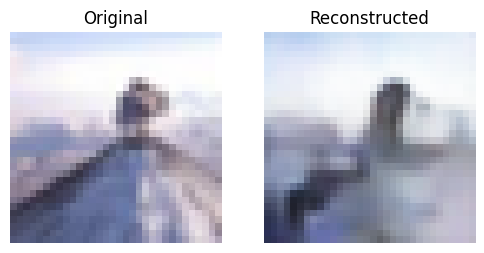

In [22]:
display_reconstruction(model, val_loader, device, n=1)

Asymmetric Autoencoders

In [23]:
# My addition - asymmetric autoencoder (currently adjusted for smaller decoder only)

def remove_dims(dims, num_layers_less, smaller_part='decoder'):
    if num_layers_less >= len(dims):
        # If num_layers_less is too large, retain only one dimension
        return [dims[0]] if smaller_part == 'encoder' else [dims[-1]]

    # if num_layers_less == 0:
        # return dims
    adjusted_dims = []

    times_skipped = 0
    if smaller_part == 'encoder':
        # Start with the first dimension included
        adjusted_dims = [dims[0]]
        skip = True  # Start by skipping the second element

        # Iterate through remaining dims from start (excluding the first element)
        for dim in dims[1:]:
          if times_skipped >= num_layers_less:
                skip = False
          times_skipped = times_skipped + 1
          if not skip:
              adjusted_dims.append(dim)
              times_skipped = times_skipped - 1
          skip = not skip  # Toggle skipping


    else:  # smaller_part == 'decoder'
        # Start with the last dimension included
        adjusted_dims = [dims[-1]]
        skip = True  # Start by skipping the second-last layer

        # Iterate through remaining dims in reverse, excluding the last element
        for dim in reversed(dims[:-1]):
          if times_skipped >= num_layers_less:
              skip = False
          times_skipped = times_skipped + 1
          if not skip:
              adjusted_dims.append(dim)
              times_skipped = times_skipped - 1
          skip = not skip  # Toggle skipping


        # Reverse back to maintain the original order
        adjusted_dims.reverse()

    return tuple(adjusted_dims)


# Function to process kernel sizes for encoder and decoder separately
def process_kernel_sizes(kernel_sizes, adjusted_dims_enc, adjusted_dims_dec):
    if isinstance(kernel_sizes, int):
        # Apply the same kernel size to all encoder and decoder layers
        kernel_sizes_enc = [kernel_sizes] * len(adjusted_dims_enc)
        kernel_sizes_dec = [kernel_sizes] * len(adjusted_dims_dec)
    else:
        # Ensure kernel_sizes is long enough for both encoder and decoder, should never get here currently
        assert len(kernel_sizes) == len(adjusted_dims_enc) + len(adjusted_dims_dec) - 2, \
        "kernel_sizes should have length equal to (encoder layers + decoder layers - 2)"

        # Split kernel_sizes between encoder and decoder
        kernel_sizes_enc = kernel_sizes[:len(adjusted_dims_enc) - 1]
        kernel_sizes_dec = kernel_sizes[len(adjusted_dims_enc) - 1:]

    # Verify each kernel size is positive
    assert all(size > 0 for size in kernel_sizes_enc + kernel_sizes_dec), \
        "All kernel sizes must be positive integers"

    return kernel_sizes_enc, kernel_sizes_dec

class DeepConvAsymmetricAutoencoder(AbstractAutoencoder):
    """ Conv AE with variable number of conv layers, where either encoder or decoder has fewer layers """
    def __init__(self, inp_side_len=32, dims=(32, 64), kernel_sizes=3, central_dim=256, pool=True, in_channels=3,
                 smaller_part='decoder', num_layers_less=1):
        """
        :param inp_side_len: Input image side length (e.g., 32 for CIFAR)
        :param dims: Dimensions of convolutional layers (e.g., (32, 64))
        :param kernel_sizes: Kernel sizes for each layer
        :param central_dim: Central bottleneck dimension
        :param pool: Whether to use pooling
        :param in_channels: Number of input channels (3 for RGB)
        :param smaller_part: 'encoder' or 'decoder', indicating which part should have fewer layers
        :param num_layers_less: How many fewer layers the smaller part should have
        """
        super().__init__()

        assert smaller_part in ['encoder', 'decoder'], "smaller_part must be 'encoder' or 'decoder'"
        assert num_layers_less >= 0, "num_layers_less must be non-negative"

        # Adjust dims based on which part is smaller
        if smaller_part == 'encoder':
            adjusted_dims_enc = remove_dims(dims, num_layers_less, smaller_part)
            adjusted_dims_dec = dims
        else:
            adjusted_dims_enc = dims
            adjusted_dims_dec = remove_dims(dims, num_layers_less, smaller_part)

        kernel_sizes_enc, kernel_sizes_dec = process_kernel_sizes(kernel_sizes, adjusted_dims_enc, adjusted_dims_dec)

        # Encoder construction
        step_pool = 1 if len(adjusted_dims_enc) < 3 else (2 if len(adjusted_dims_enc) < 6 else 3)
        side_len = inp_side_len
        side_lengths = [side_len]

        adjusted_dims_enc = (in_channels, *adjusted_dims_enc)  # Set the first dimension to input channels
        adjusted_dims_dec = (in_channels, *adjusted_dims_dec)  # Ensure the last dimension matches input channels

        enc_layers = []
        for i in range(len(adjusted_dims_enc) - 1):
            pad = (kernel_sizes_enc[i] - 1) // 2
            enc_layers.append(nn.Conv2d(in_channels=adjusted_dims_enc[i], out_channels=adjusted_dims_enc[i + 1],
                                        kernel_size=kernel_sizes_enc[i], padding=pad, stride=1))
            enc_layers.append(nn.ReLU(inplace=True))
            if pool and (i % step_pool == 0 or i == len(adjusted_dims_enc) - 1) and side_len > 3:
                enc_layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
                side_len = math.floor(side_len / 2)
                side_lengths.append(side_len)

        fc_dims_enc = (side_len ** 2 * adjusted_dims_enc[-1], side_len ** 2 * adjusted_dims_enc[-1] // 2, central_dim)
        fc_dims_dec = (side_len ** 2 * adjusted_dims_dec[-1], side_len ** 2 * adjusted_dims_dec[-1] // 2, central_dim)
        self.encoder = nn.Sequential(
            *enc_layers,
            nn.Flatten(),
            nn.Linear(fc_dims_enc[0], fc_dims_enc[1]),
            nn.ReLU(inplace=True),
            nn.Linear(fc_dims_enc[1], fc_dims_enc[2]),
            nn.ReLU(inplace=True)
        )

        # Decoder construction
        central_side_len = side_lengths.pop(-1)
        dec_layers = []
        for i in reversed(range(1, len(adjusted_dims_dec))):
            kersize = 2 if len(side_lengths) > 0 and side_len * 2 == side_lengths.pop(-1) else 3
            pad, stride = (1, 1) if side_len == inp_side_len else (0, 2)
            dec_layers.append(nn.ConvTranspose2d(in_channels=adjusted_dims_dec[i], out_channels=adjusted_dims_dec[i - 1], kernel_size=kersize,
                                                padding=pad, stride=stride))
            side_len = side_len if pad == 1 else (side_len * 2 if kersize == 2 else side_len * 2 + 1)
            dec_layers.append(nn.ReLU(inplace=True))
        dec_layers[-1] = nn.Sigmoid()

        self.decoder = nn.Sequential(
            nn.Linear(fc_dims_dec[2], fc_dims_dec[1]),
            nn.ReLU(inplace=True),
            nn.Linear(fc_dims_dec[1], fc_dims_dec[0]),
            nn.ReLU(inplace=True),
            nn.Unflatten(dim=1, unflattened_size=(dims[-1], central_side_len, central_side_len)),
            *dec_layers,
        )

In [24]:
# In order to solve the model's crashing for the 10 dims (out of memory)
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [25]:
# Instantiate your model
asym_model_minus2 = DeepConvAsymmetricAutoencoder(
    inp_side_len=32,  # CIFAR-100 images are 32x32
    dims=(32, 64, 128, 256, 512),    # 5 layers
    kernel_sizes=3,
    central_dim=256,
    num_layers_less=2,
    in_channels=3  # CIFAR-100 has 3 channels (RGB)
).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(asym_model_minus2.parameters(), lr=0.001)

In [26]:
save_dir_asymmetric_ae_minus2 = '/content/gdrive/My Drive/checkpoints/AsymmetricAutoencoderMinus2'
start_epoch_asym_minus2 = load_checkpoint(asym_model_minus2, save_dir_asymmetric_ae_minus2, num_epochs)

<ipython-input-13-c97416bc3fbe>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))


In [27]:
train_model(asym_model_minus2, start_epoch_asym_minus2, num_epochs, save_dir_asymmetric_ae_minus2, train_loader, val_loader, criterion, optimizer, device)

Starting training from epoch 252
Finished Training


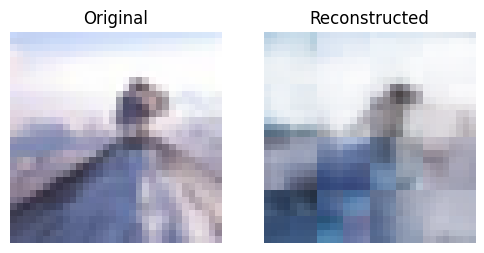

In [28]:
display_reconstruction(asym_model_minus2, val_loader, device, n=1)

In [29]:
# Instantiate your model
asym_model_minus1 = DeepConvAsymmetricAutoencoder(
    inp_side_len=32,  # CIFAR-100 images are 32x32
    dims=(32, 64, 128, 256, 512),    # 5 layers
    kernel_sizes=3,
    central_dim=256,
    in_channels=3  # CIFAR-100 has 3 channels (RGB)
).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(asym_model_minus1.parameters(), lr=0.001)

In [30]:
save_dir_asymmetric_ae_minus1 = '/content/gdrive/My Drive/checkpoints/AsymmetricAutoencoderMinus1'
start_epoch_asym_minus1 = load_checkpoint(asym_model_minus1, save_dir_asymmetric_ae_minus1, num_epochs)

<ipython-input-13-c97416bc3fbe>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, latest_checkpoint_file)))


In [31]:
train_model(asym_model_minus1, start_epoch_asym_minus1, num_epochs, save_dir_asymmetric_ae_minus1, train_loader, val_loader, criterion, optimizer, device)

Starting training from epoch 252
Finished Training


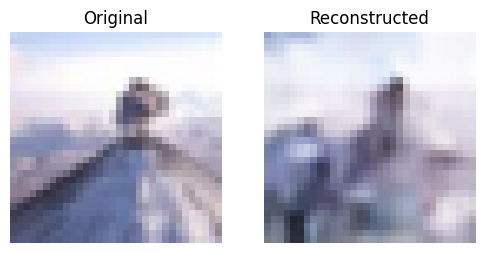

In [32]:
display_reconstruction(asym_model_minus1, val_loader, device, n=1)

In [33]:
'''
sym_model_by_asym_code = DeepConvAsymmetricAutoencoder(
    inp_side_len=32,  # CIFAR-100 images are 32x32
    dims=(32, 64, 128, 256, 512),    # 5 layers
    kernel_sizes=3,
    central_dim=256,
    num_layers_less=0,
    in_channels=3  # CIFAR-100 has 3 channels (RGB)
).to(device)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(sym_model_by_asym_code.parameters(), lr=0.001)

save_dir_symmetric_by_asymmetric_code = '/content/gdrive/My Drive/checkpoints/SymmetricAutoencoderByAsymmetricCode'
start_epoch_symmetric_by_asym_code = load_checkpoint(sym_model_by_asym_code, save_dir_symmetric_by_asymmetric_code, num_epochs)

train_model(
    sym_model_by_asym_code,
    start_epoch_symmetric_by_asym_code,
    num_epochs,
    save_dir_symmetric_by_asymmetric_code,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device
)

display_reconstruction(sym_model_by_asym_code, val_loader, device, n=1)
'''

"\nsym_model_by_asym_code = DeepConvAsymmetricAutoencoder(\n    inp_side_len=32,  # CIFAR-100 images are 32x32\n    dims=(32, 64, 128, 256, 512),    # 5 layers\n    kernel_sizes=3,\n    central_dim=256,\n    num_layers_less=0,\n    in_channels=3  # CIFAR-100 has 3 channels (RGB)\n).to(device)\n\n\n# Define loss function and optimizer\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(sym_model_by_asym_code.parameters(), lr=0.001)\n\nsave_dir_symmetric_by_asymmetric_code = '/content/gdrive/My Drive/checkpoints/SymmetricAutoencoderByAsymmetricCode'\nstart_epoch_symmetric_by_asym_code = load_checkpoint(sym_model_by_asym_code, save_dir_symmetric_by_asymmetric_code, num_epochs)\n\ntrain_model(\n    sym_model_by_asym_code,\n    start_epoch_symmetric_by_asym_code,\n    num_epochs,\n    save_dir_symmetric_by_asymmetric_code,\n    train_loader,\n    val_loader,\n    criterion,\n    optimizer,\n    device\n)\n\ndisplay_reconstruction(sym_model_by_asym_code, val_loader, device, n=1)\n"